### call utility functions to get the analysis file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import dhs_util
from dhs_util import *

os.chdir('/Users/yingli/Development/TopicsInDataScience/')
df = pd.read_csv('dhs_service_records_synthesized_final.csv')

df = dhs_preprocessing(df)
df, service_map = add_service_label(df)
df = add_age_bin(df)

recipient = get_recipient_attribute(df)

In [2]:
df.shape

(7116134, 12)

In [3]:
recipient.shape

(533799, 15)

In [4]:
recipient.head()

,id,num_service,distinct_service,first_date,last_date,num_month,distinct_month,age,gender,race,ethnicity,marital,education,serv,age_bin
0,1,12,1,2021-01-31,2021-12-31,12,12,13,1~Male,99~Unknown,2~Not Hispanic/Latinx,99~Unknown,GED~High School Diploma/GED Completed,S12,10-19
12,2,1,1,2021-02-28,2021-02-28,1,1,70,2~Female,1~White,2~Not Hispanic/Latinx,2~Married,99~Unknown,S12,70-79
13,3,11,1,2021-02-28,2021-12-31,11,11,29,2~Female,1~White,2~Not Hispanic/Latinx,2~Married,9-12~High School (grade 9-12),S12,20-29
24,4,4,1,2021-03-31,2021-12-31,4,4,4,2~Female,1~White,2~Not Hispanic/Latinx,1~Single-Never Married,9-12~High School (grade 9-12),S12,0-9
28,5,12,1,2021-01-31,2021-12-31,12,12,40,1~Male,2~Black/African American,2~Not Hispanic/Latinx,2~Married,UNDERGRAD~Some College,S12,40-49


In [5]:
df.date.unique()

<DatetimeArray>
['2021-01-31 00:00:00', '2021-02-28 00:00:00', '2021-03-31 00:00:00',
 '2021-04-30 00:00:00', '2021-05-31 00:00:00', '2021-06-30 00:00:00',
 '2021-07-31 00:00:00', '2021-08-31 00:00:00', '2021-09-30 00:00:00',
 '2021-10-31 00:00:00', '2021-11-30 00:00:00', '2021-12-31 00:00:00']
Length: 12, dtype: datetime64[ns]

## In class exercises
Answer the following questions:
 - 
 - do the number of services per recipient increase over time?  - What else can you observe from the data?

In [6]:
serv_data = []
for groups in df.groupby('id').groups.values():
    serv_data.append(df.loc[groups]['serv'].tolist())
serv_data[:10]

[['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12'],
 ['S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12'],
 ['S12', 'S12', 'S12', 'S12'],
 ['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S09',
  'S09',
  'S09',
  'S09',
  'S09',
  'S09',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12'],
 ['S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',


In [7]:
serv_data[:10]

[['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12'],
 ['S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12'],
 ['S12', 'S12', 'S12', 'S12'],
 ['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S09',
  'S09',
  'S09',
  'S09',
  'S09',
  'S09',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12'],
 ['S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',


* another way to do the same

In [8]:
serv_data_n = []
for groups in df.groupby('id').groups.values():
    serv_data_n.append(list(df.loc[groups]['serv'].to_numpy()))
serv_data_n[:10]


[['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12'],
 ['S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12'],
 ['S12', 'S12', 'S12', 'S12'],
 ['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S09',
  'S09',
  'S09',
  'S09',
  'S09',
  'S09',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12'],
 ['S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12', 'S12'],
 ['S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S11',
  'S12',
  'S12',
  'S12',
  'S12',
  'S12',


* check equality

In [9]:
serv_data == serv_data_n

True

### use mlxtend package

In [10]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.preprocessing import *
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpmax

def oneHotCoding(serv_data):
    te = TransactionEncoder()
    te_ary = te.fit(serv_data).transform(serv_data)
    te_df = pd.DataFrame(te_ary, columns=te.columns_)
    return te_df

serv_oneHot = oneHotCoding(serv_data)

In [11]:
serv_oneHot

,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,...,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533794,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
533795,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
533796,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
533797,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False


* we have done something like this earlier, recall? 

In [12]:
apriori(serv_oneHot, min_support=0.018) 

,support,itemsets
0,0.153844,(8)
1,0.040882,(10)
2,0.941422,(11)
3,0.103528,(13)
4,0.024002,(14)
5,0.031396,(18)
6,0.018307,"(8, 10)"
7,0.139131,"(8, 11)"
8,0.103528,"(8, 13)"
9,0.019431,"(8, 14)"


In [13]:
min_freq = 1000
min_support = min_freq/serv_oneHot.shape[0]
min_confidence = 0.6
min_rule_support = 0.2
min_lift = 0.15

In [14]:
apriori(serv_oneHot, min_support=min_support)

,support,itemsets
0,0.004191,(1)
1,0.013687,(2)
2,0.002244,(3)
3,0.012649,(4)
4,0.005841,(5)
...,...,...
141,0.001982,"(8, 16, 13, 14)"
142,0.003831,"(8, 17, 13, 15)"
143,0.002879,"(17, 11, 13, 15)"
144,0.002055,"(6, 8, 10, 11, 13)"


In [15]:
freq_itemsets_apriori = apriori(serv_oneHot,min_support=min_support,use_colnames=True)
freq_itemsets_apriori.describe()

,support
count,146.000000
mean,0.017443
std,0.080320
min,0.001875
25%,0.002868
50%,0.004436
75%,0.009374
max,0.941422


In [16]:
freq_itemsets_fpgrowth = fpgrowth(serv_oneHot,min_support=min_support,use_colnames=True)
freq_itemsets_fpgrowth.describe()

,support
count,146.000000
mean,0.017443
std,0.080320
min,0.001875
25%,0.002868
50%,0.004436
75%,0.009374
max,0.941422


In [17]:
freq_itemsets_fpmax = fpmax(serv_oneHot,min_support=min_support,use_colnames=True)
freq_itemsets_fpmax.describe()

,support
count,22.000000
mean,0.003213
std,0.001915
min,0.001875
25%,0.002171
50%,0.002484
75%,0.003357
max,0.009342


In [18]:
# compute and print the association rules
def serv_rules(freq_itemsets,metrics,threshold):
    asso_rules = association_rules(freq_itemsets, metric=metrics, min_threshold=threshold)
    return asso_rules.sort_values(by='lift', ascending=False)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

rules_apriori = serv_rules(freq_itemsets_apriori,"confidence",0.60)
rules_fpgrowth = serv_rules(freq_itemsets_fpgrowth,"confidence",0.60)

In [19]:
rules_fpgrowth

,antecedents,consequents,support,confidence,lift
126,"(S06, S09)","(S21, S12)",0.002486,0.857789,96.948349
125,"(S06, S12)","(S21, S09)",0.002486,0.722767,90.929116
209,"(S02, S09)","(S12, S03)",0.002182,0.969218,78.903093
204,(S02),"(S12, S03)",0.003921,0.935628,76.168573
124,"(S09, S12, S06)",(S21),0.002486,0.987351,74.462712
...,...,...,...,...,...
116,"(S21, S06)",(S12),0.003215,0.701554,0.745206
83,(S17),(S12),0.008674,0.668882,0.710502
102,(S21),(S12),0.008848,0.667279,0.708799
26,"(S09, S19)",(S12),0.003432,0.651494,0.692032


In [20]:
def predict(antecedent, rules, consequents_only = False):
    
    # get the rules for this antecedent
    preds = rules[rules['antecedents'] == antecedent]
    if consequents_only:
        # a way to convert a frozen set with one element to string
        preds = preds['consequents'].apply(iter).apply(next)
    return preds

In [21]:
rules_fpmax = association_rules(freq_itemsets_fpmax, metric="confidence", min_threshold=0.001, support_only=True)

In [22]:
predict({"S09"}, rules_fpmax, consequents_only=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
5,(S09),"(S02, S14)",NaN,NaN,0.001875,NaN,NaN,NaN,NaN,NaN
18,(S09),"(S02, S12, S03)",NaN,NaN,0.002182,NaN,NaN,NaN,NaN,NaN
25,(S09),"(S10, S12)",NaN,NaN,0.002754,NaN,NaN,NaN,NaN,NaN
38,(S09),"(S21, S12, S06)",NaN,NaN,0.002486,NaN,NaN,NaN,NaN,NaN
66,(S09),"(S11, S12, S07, S14)",NaN,NaN,0.002055,NaN,NaN,NaN,NaN,NaN
97,(S09),"(S18, S14, S12, S16)",NaN,NaN,0.002879,NaN,NaN,NaN,NaN,NaN
111,(S09),"(S14, S12, S13)",NaN,NaN,0.004436,NaN,NaN,NaN,NaN,NaN
128,(S09),"(S17, S14, S15)",NaN,NaN,0.001982,NaN,NaN,NaN,NaN,NaN
142,(S09),"(S17, S12, S15)",NaN,NaN,0.002482,NaN,NaN,NaN,NaN,NaN
156,(S09),"(S14, S17, S12)",NaN,NaN,0.003945,NaN,NaN,NaN,NaN,NaN


In [23]:
predict({"S09"}, rules_fpmax, consequents_only=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
5,(S09),"(S02, S14)",NaN,NaN,0.001875,NaN,NaN,NaN,NaN,NaN
18,(S09),"(S02, S12, S03)",NaN,NaN,0.002182,NaN,NaN,NaN,NaN,NaN
25,(S09),"(S10, S12)",NaN,NaN,0.002754,NaN,NaN,NaN,NaN,NaN
38,(S09),"(S21, S12, S06)",NaN,NaN,0.002486,NaN,NaN,NaN,NaN,NaN
66,(S09),"(S11, S12, S07, S14)",NaN,NaN,0.002055,NaN,NaN,NaN,NaN,NaN
97,(S09),"(S18, S14, S12, S16)",NaN,NaN,0.002879,NaN,NaN,NaN,NaN,NaN
111,(S09),"(S14, S12, S13)",NaN,NaN,0.004436,NaN,NaN,NaN,NaN,NaN
128,(S09),"(S17, S14, S15)",NaN,NaN,0.001982,NaN,NaN,NaN,NaN,NaN
142,(S09),"(S17, S12, S15)",NaN,NaN,0.002482,NaN,NaN,NaN,NaN,NaN
156,(S09),"(S14, S17, S12)",NaN,NaN,0.003945,NaN,NaN,NaN,NaN,NaN


In [24]:
predict({"S09"}, rules_fpgrowth)


,antecedents,consequents,support,confidence,lift
14,(S09),"(S14, S12)",0.094436,0.613843,6.500073
9,(S09),(S14),0.103528,0.672938,6.500073
0,(S09),(S12),0.139131,0.904362,0.960634


In [25]:
len(predict({"S01"},rules_fpgrowth))

0

In [26]:
serv_list =  ['S'+str(i).zfill(2) for i in range(1,23)]
for i in serv_list:
    print(i)
    if (len(predict({i},rules_fpgrowth))>0):
        print(i), print(predict({i},rules_fpgrowth))

S01
S02
S02
    antecedents consequents   support  confidence       lift
204       (S02)  (S12, S03)  0.003921    0.935628  76.168573
200       (S02)       (S03)  0.004142    0.988377  72.213908
201       (S02)       (S12)  0.003970    0.947251   1.006192
S03
S03
   antecedents consequents   support  confidence      lift
16       (S03)       (S12)  0.012284    0.897482  0.953326
S04
S05
S05
    antecedents consequents   support  confidence      lift
175       (S05)       (S12)  0.008057    0.636996  0.676632
S06
S06
    antecedents consequents   support  confidence       lift
115       (S06)       (S21)  0.004582    0.784477  59.162639
S07
S07
    antecedents consequents   support  confidence       lift
141       (S07)  (S11, S12)  0.005105     0.79795  24.853835
137       (S07)       (S11)  0.006398     1.00000  24.460386
138       (S07)       (S12)  0.005105     0.79795   0.847601
S08
S09
S09
   antecedents consequents   support  confidence      lift
14       (S09)  (S14, S12)  0.094

In [27]:
rules_fpgrowth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 126 to 175
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   antecedents  212 non-null    object 
 1   consequents  212 non-null    object 
 2   support      212 non-null    float64
 3   confidence   212 non-null    float64
 4   lift         212 non-null    float64
dtypes: float64(3), object(2)
memory usage: 9.9+ KB


In [28]:
rules_fpgrowth.sort_values("support",ascending=False)


,antecedents,consequents,support,confidence,lift
0,(S09),(S12),0.139131,0.904362,0.960634
8,(S14),(S09),0.103528,1.000000,6.500073
9,(S09),(S14),0.103528,0.672938,6.500073
15,(S14),"(S09, S12)",0.094436,0.912184,6.556292
11,"(S09, S12)",(S14),0.094436,0.678758,6.556292
...,...,...,...,...,...
198,"(S11, S18, S14)",(S09),0.001930,1.000000,6.500073
197,"(S11, S18, S09)",(S14),0.001930,0.999030,9.649879
196,"(S11, S18)",(S14),0.001930,0.999030,9.649879
211,"(S02, S09)",(S14),0.001875,0.832779,8.044016


In [29]:
df[(df.serv=="S09")].merge(df[(df.serv =="S12")], on = "id").id.nunique()/df.id.nunique()

0.1391310212270911

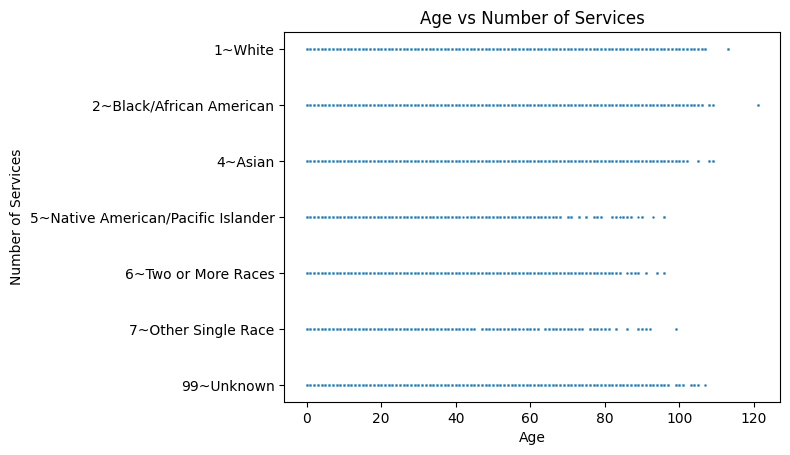

In [30]:
#make a scatterplot between age and number of services in the client_attributes dataset

sns.scatterplot(data = df, x = 'age', y = 'race', s = 2)
plt.title('Age vs Number of Services')
plt.xlabel('Age')
plt.ylabel('Number of Services')
plt.show()

In [31]:
import itertools
j = 0
for i in itertools.combinations(df.service.unique(),2):
    j=j+1
    print(j), print(i)

1
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Children_in_Care')
2
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Children_Receiving_Child_Welfare_Services')
3
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Children_Receiving_DHS_Funded_Out_of_School_Programs')
4
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Children_Receiving_Early_Intervention_Services')
5
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Families_Receiving_Child_Welfare_Services')
6
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Homeless_Population')
7
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Homicides')
8
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Individuals_Receiving_DHS_Services')
9
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Individuals_Receiving_Family_Strengthening_Programs')
10
('Children_Attending_Early_Childhood_Programs_Managed_by_DHS', 'Ind